In [1]:
import sys
sys.path.append('..\\..\\..\\..')

In [2]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')

In [3]:
tf.__version__

'2.0.0'

In [4]:
dataset_name = 'dsprites'

In [5]:
import tensorflow_datasets as tfds

info = tfds.builder(dataset_name).info

print(info)

tfds.core.DatasetInfo(
    name='dsprites',
    version=0.1.0,
    description='dSprites is a dataset of 2D shapes procedurally generated from 6 ground truth
independent latent factors. These factors are *color*, *shape*, *scale*,
*rotation*, *x* and *y* positions of a sprite.

All possible combinations of these latents are present exactly once,
generating N = 737280 total images.

### Latent factor values

*   Color: white
*   Shape: square, ellipse, heart
*   Scale: 6 values linearly spaced in [0.5, 1]
*   Orientation: 40 values in [0, 2 pi]
*   Position X: 32 values in [0, 1]
*   Position Y: 32 values in [0, 1]

We varied one latent at a time (starting from Position Y, then Position X, etc),
and sequentially stored the images in fixed order.
Hence the order along the first dimension is fixed and allows you to map back to
the value of the latents corresponding to that image.

We chose the latents values deliberately to have the smallest step changes
while ensuring that all pixel outp

In [6]:
intermediate_dim = 20
inputs_shape=(64, 64, 1) # image shape
batch_size = 100
latent_dim = 50

In [7]:
TRAIN_BUF = 600
TEST_BUF = 100


In [8]:
import tensorflow_datasets as tfds
# Construct a tf.data.Dataset
train_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TRAIN_BUF).batch(batch_size)
try:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TEST).shuffle(TEST_BUF).batch(batch_size)
except:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TEST_BUF).batch(batch_size)


In [9]:
_instance_scale=1.0
for data in train_ds:
    _instance_scale = float(data['image'][0].numpy().max())
    break

In [10]:
enc_lays2 = [
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(latent_dim)
]

enc_lays3 = [
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(latent_dim)
]

dec_lays2 = [
    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    
    # No activation
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")
]

In [11]:
enc_mean_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

enc_var_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

dec_lays = [tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu')]

## First Time

In [12]:
#from utils.data_and_files.file_utils import make_random_string
#from time import gmtime, strftime

#model_name = 'AE_' + make_random_string(5) + strftime("%a_%d_%b_%Y_%H_%M", gmtime())
#print(model_name)

In [13]:
model_name = dataset_name+'VAE'

In [14]:
recoding_dir='..\\..\\..\\..\\recoding\\'+model_name

In [15]:
import os

In [16]:
os.path.join(recoding_dir, model_name)

'..\\..\\recoding\\dspritesVAE\\dspritesVAE'

In [17]:
from training.autoencoders.VAE import VAE

Using TensorFlow backend.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [18]:
variables_params = \
[
    {
        'name': 'encoder_mean', 
        'inputs_shape':inputs_shape,
        'outputs_shape':latent_dim,
        'layers': enc_lays2
    }
    ,
    
     {
        'name': 'encoder_logvar', 
        'inputs_shape':inputs_shape,
        'outputs_shape':latent_dim,
        'layers':enc_lays3
    }
    ,
    
        {
        'name': 'generative', 
        'inputs_shape':latent_dim,
        'outputs_shape':inputs_shape,
        'layers':dec_lays2
    }
]

In [19]:
_restore = os.path.join(recoding_dir, 'var_save_dir')

In [20]:
_restore

'..\\..\\recoding\\dspritesVAE\\var_save_dir'

In [24]:
vae = VAE( 
    model_name=model_name, 
    inputs_shape=inputs_shape, 
    outputs_shape = inputs_shape,
    latent_dim= latent_dim, 
    variables_params=variables_params, 
    restore=None
    )

Model: "encoder_mean"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                720050    
_________________________________________________________________
flatten_2 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization (BatchNo (None, 50)               

  WARNING  | None


Model: "encoder_logvar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 31, 31, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                720050    
_________________________________________________________________
flatten_3 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)             

  WARNING  | None


Model: "generative"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1568)              79968     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 4096)              3

  WARNING  | None


In [27]:
import numpy as np
n_generated = 36
random_latent = np.random.normal(size=[n_generated, latent_dim])
#np.save(file='random_latent.npy', arr=random_latent)
#random_latent = tf.constant(np.load(file='..\\data\\random_latent.npy'))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



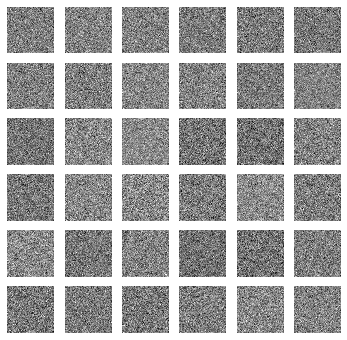

  ERROR    | No former training found ... 
Epochs Progress:   0%|                                                                         | 0/500 [00:00<?, ?it/s]

  INFO     | Training ... 
Epochs Progress, Training Iterations 9:   0%|                                                  | 0/500 [00:19<?, ?it/s]

KeyboardInterrupt: 

In [28]:
vae.fit(
    train_dataset=train_ds, 
    test_dataset=test_ds,
    instance_names=['image'],
    epochs=500,
    learning_rate=1e-3,
    random_latent=random_latent,
    recoding_dir=recoding_dir,
    gray_plot=True,
    generate_epoch=5,
    save_epoch=5
)

In [ ]:
#The Cells below are old Ground truth Metrics measurements 
#now they are logged and saved with losses in the same manner during training 

In [ ]:
DATA_PATH = '..\\data\\gt_datasets'

In [ ]:
from data.gt_load.datasets import load

In [ ]:
eval_dataset = load(dataset_name='dsprites_full', dataset_path=DATA_PATH)

In [ ]:
def rep_func(x):
    z, mean, logvar = vae.encode(x)
    return z

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from evaluation.unsupervised_metrics.compute_metrics import compute_unsupervised_metrics

In [ ]:
us_scores = compute_unsupervised_metrics(
    ground_truth_data=eval_dataset, 
    representation_function=rep_func, 
    random_state=np.random.RandomState(0),
    num_train=10000,
    batch_size=batch_size
)
    

In [ ]:
us_scores

In [ ]:
from evaluation.supervised_metrics.compute_metrics import compute_supervised_metrics

In [ ]:
s_scores = compute_supervised_metrics(
    ground_truth_data=eval_dataset, 
    representation_function=rep_func, 
    random_state=np.random.RandomState(0),
    num_train=10000,
    num_test=2000,
    continuous_factors=False,
    batch_size=batch_size
)
    

In [ ]:
s_scores